# Load data

In [1]:
import mne
from mne.time_frequency import psd_array_welch
import os

In [2]:
# try:
sample_data_folder = mne.datasets.sample.data_path()
# except AttributeError:
#     sample_data_folder = '../../mne_data/MNE-sample-data'
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)

Opening raw data file /Users/moritzgerster/Library/CloudStorage/Dropbox/Code/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


# Set annotation

### Note that two bad segments are separated by only 500 ms of good data.

In [3]:
annotations = mne.Annotations(onset=[5, 6.5], duration=[1, 1], description=['bad', 'bad'])
raw.set_annotations(annotations)

Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus, 59 EEG, 1 EOG"
Bad channels,"MEG 2443, EEG 053"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


In [4]:
raw.plot();

Using qt as 2D backend.
Using pyopengl with version 3.1.6


2024-12-21 09:42:21.570 python[29841:52635802] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-21 09:42:21.570 python[29841:52635802] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Channels marked as bad:
['MEG 2443', 'EEG 053']


## Set n_fft to sample rate and n_overlap to n_fft/2 -> 50% overlap = 500 ms

In [5]:
n_fft = int(raw.info["sfreq"])
n_overlap = n_fft // 2

# psd_array_welch fails

In [6]:
psds, freqs = psd_array_welch(raw.get_data(reject_by_annotation='NaN'), n_fft, n_fft=n_fft, n_overlap=n_overlap)

Setting 1202 of 166800 (0.72%) samples to NaN, retaining 165598 (99.28%) samples.
Effective window size : 1.000 (s)


# raw.compute_psd fails

In [13]:
spectrum = raw.compute_psd(method="welch", n_fft=n_fft, n_overlap=n_overlap)

AttributeError: 'Raw' object has no attribute 'compute_psd'

# specifying n_per_seg explicitly does not help

In [8]:
n_per_seg = n_fft
assert n_overlap < n_per_seg

In [ ]:
spectrum = raw.compute_psd(method="welch", n_fft=n_fft, n_overlap=n_overlap, n_per_seg=n_per_seg)

Setting 1202 of 166800 (0.72%) samples to NaN, retaining 165598 (99.28%) samples.
Effective window size : 0.999 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.


/Users/moritzgerster/anaconda3/envs/local_sns013/lib/python3.12/site-packages/mne/time_frequency/psd.py:266: UserWarning: nperseg = 600 is greater than input length  = 300, using nperseg = 300
  return _func(*args, **kwargs)


ValueError: noverlap must be less than nperseg.

# Tested for mne 1.7 and 1.8

In [7]:
mne.sys_info()

Platform             macOS-15.1.1-arm64-arm-64bit
Python               3.12.5 | packaged by conda-forge | (main, Aug  8 2024, 18:32:50) [Clang 16.0.6 ]
Executable           /Users/moritzgerster/anaconda3/envs/local_sns013/bin/python
CPU                  arm (10 cores)
Memory               16.0 GB

Core
├☒ mne               1.7.1 (outdated, release 1.9.0 is available!)
├☑ numpy             2.0.1 (OpenBLAS 0.3.27 with 10 threads)
├☑ scipy             1.14.0
└☑ matplotlib        3.9.1 (backend=module://matplotlib_inline.backend_inline)

Numerical (optional)
├☑ sklearn           1.5.1
├☑ numba             0.60.0
├☑ nibabel           5.2.1
├☑ nilearn           0.10.4
├☑ pandas            2.2.2
├☑ h5io              0.2.4
├☑ h5py              3.11.0
└☐ unavailable       dipy, openmeeg, cupy

Visualization (optional)
└☐ unavailable       pyvista, pyvistaqt, vtk, qtpy, ipympl, pyqtgraph, mne-qt-browser, ipywidgets, trame_client, trame_server, trame_vtk, trame_vuetify

Ecosystem (optional)
├☑ mn

In [8]:
import numpy as np
import mne

def extend_bad_segments(raw, min_gap=0.5):
    """
    Extend durations of bad segments in raw.annotations to fill short gaps
    between consecutive bad segments, including gaps at the start and end of the recording if they are shorter than `min_gap`.

    Parameters
    ----------
    raw : mne.io.Raw
        The raw object whose annotations will be modified.
    min_gap : float
        Minimum gap (in seconds) between consecutive bad segments. If the gap is
        less than this, the bad segments will be merged.

    Returns
    -------
    raw : mne.io.Raw
        The raw object with updated annotations.
    """
    # Get existing annotations
    annotations = raw.annotations

    # Adjust annotations to account for raw.first_time
    adjusted_onsets = annotations.onset - raw.first_time
    bad_segments = [
        (onset, onset + duration)
        for onset, duration, description in zip(adjusted_onsets,
                                                annotations.duration,
                                                annotations.description)
        if description.lower().startswith('bad')
    ]

    # If no bad segments, return raw object unchanged
    if not bad_segments:
        print("No 'bad' segments found. Returning raw object unchanged.")
        return raw

    # Sort segments by onset time
    bad_segments.sort()

    # Merge overlapping or closely spaced segments
    merged_segments = []
    current_start, current_end = bad_segments[0]

    for next_start, next_end in bad_segments[1:]:
        if next_start - current_end <= min_gap:  # Merge segments
            current_end = max(current_end, next_end)
        else:  # Save current segment and start a new one
            merged_segments.append((current_start, current_end))
            current_start, current_end = next_start, next_end
    # Add the last segment
    merged_segments.append((current_start, current_end))

    # Handle edge cases: Extend to start if needed
    if merged_segments[0][0] > 0 and merged_segments[0][0] <= min_gap:
        merged_segments[0] = (0, merged_segments[0][1])

    # Handle edge cases: Extend to end if needed
    if merged_segments[-1][1] < raw.times[-1] and raw.times[-1] - merged_segments[-1][1] <= min_gap:
        merged_segments[-1] = (merged_segments[-1][0], raw.times[-1])

    # Create updated annotations
    new_annotations = mne.Annotations([], [], [])
    for onset, end in merged_segments:
        new_annotations.append(onset=onset + raw.first_time, duration=end - onset, description='bad')

    # Retain non-bad annotations
    for onset, duration, description in zip(adjusted_onsets, annotations.duration, annotations.description):
        if not description.lower().startswith('bad'):
            new_annotations.append(onset=onset + raw.first_time, duration=duration, description=description)

    # Update raw object with new annotations
    new_annotations.onset -= raw.first_time
    raw.set_annotations(new_annotations)
    return raw


In [9]:
raw = mne.io.read_raw_fif(sample_data_raw_file)
annotations = mne.Annotations(onset=[.3, 1, 1.3, 5, 6.5], duration=[.2, 0.2, .5, 1, 1], description='bad')
raw.set_annotations(annotations)

Opening raw data file /Users/moritzgerster/Library/CloudStorage/Dropbox/Code/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus, 59 EEG, 1 EOG"
Bad channels,"MEG 2443, EEG 053"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


In [10]:
len(raw.annotations)

5

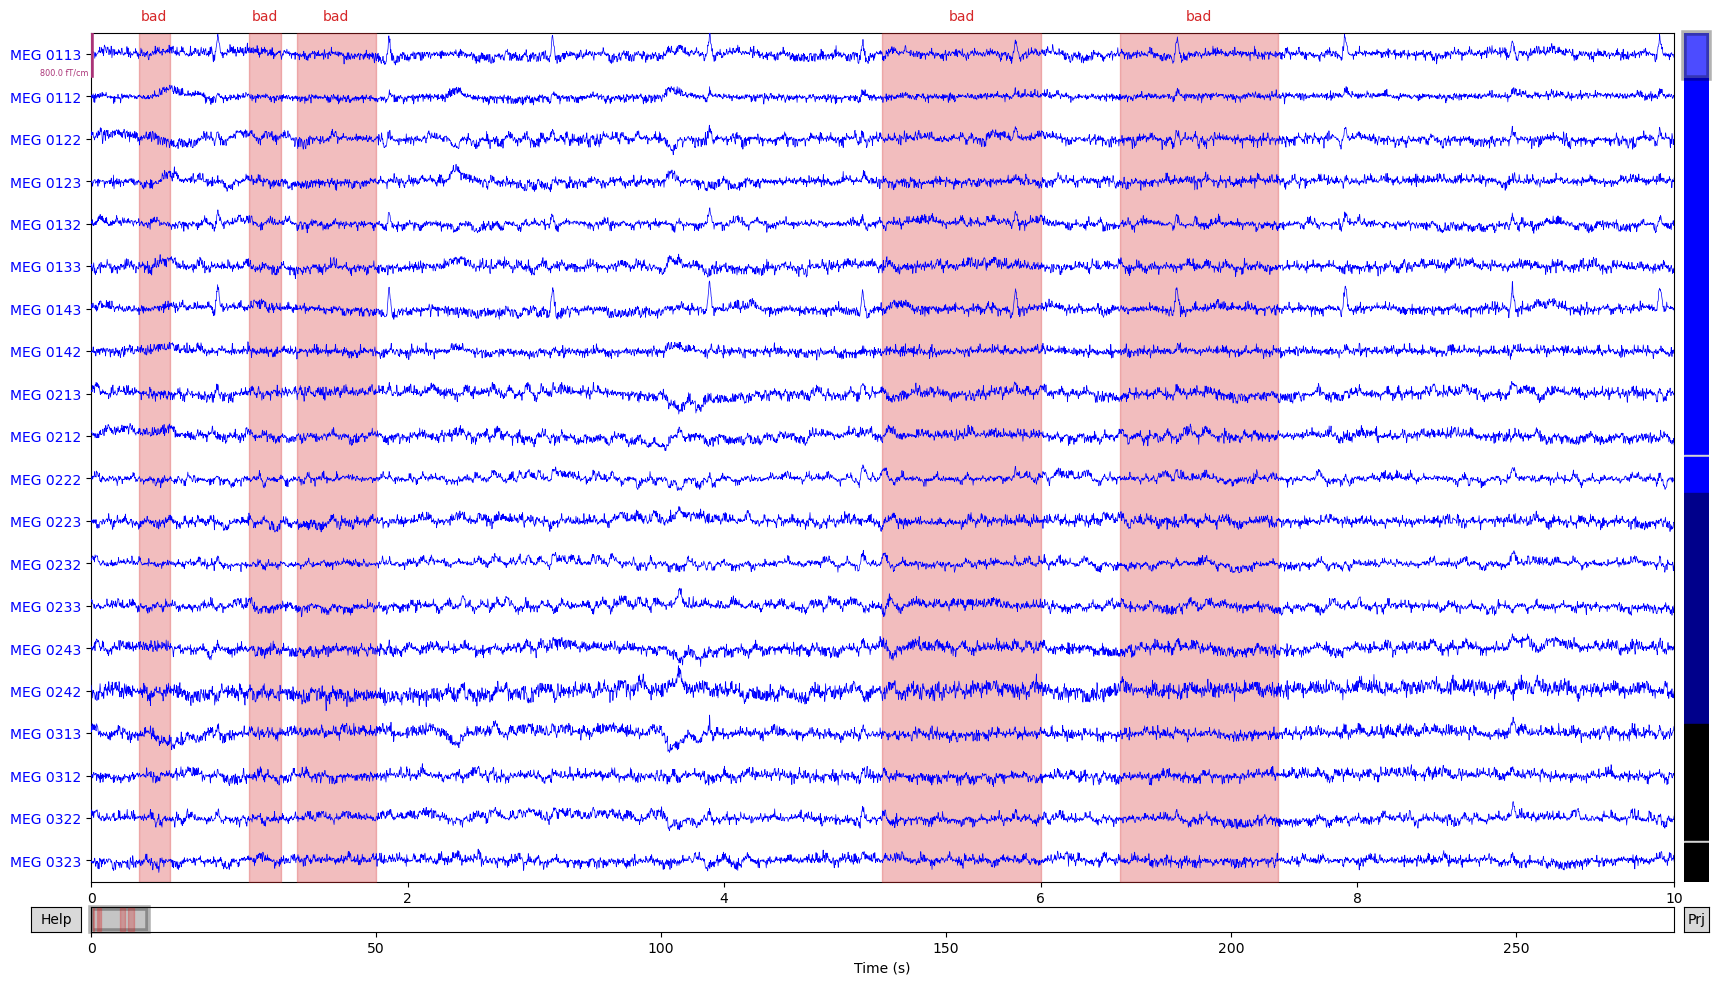

In [11]:
raw.plot();

In [12]:
raw = extend_bad_segments(raw, min_gap=0.5)

In [13]:
len(raw.annotations)

3

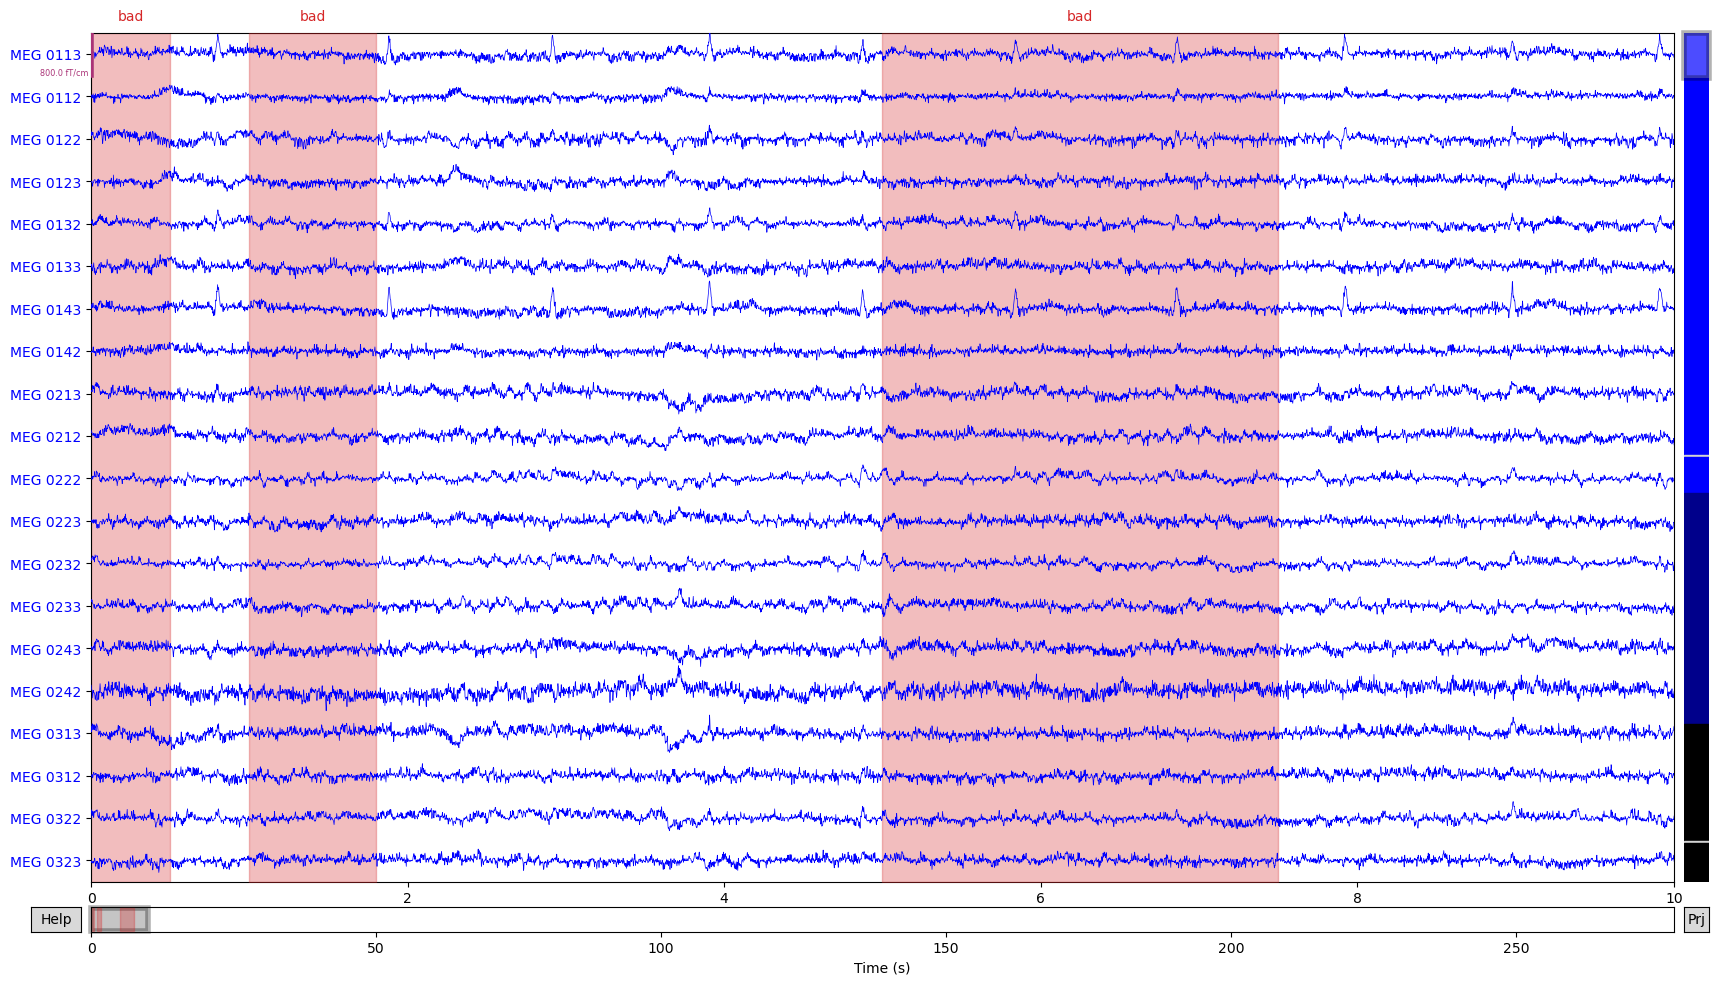

In [14]:
raw.plot();

In [15]:
spectrum = raw.compute_psd(method="welch", n_fft=n_fft, n_overlap=n_overlap, n_per_seg=n_per_seg)

NameError: name 'n_per_seg' is not defined

In [18]:
fpath = '../derivatives/preprocessed/sub-FloML002/ses-LfpMedOff01/ieeg/sub-FloML002_ses-LfpMedOff01_task-Rest_acq-StimOff_run-01_proc-Highpass_rec-Florin_desc-cleaned_ieeg.fif'
# fpath = '../derivatives/preprocessed/sub-FloML007/ses-LfpMedOn01/ieeg/sub-FloML007_ses-LfpMedOn01_task-Rest_acq-StimOff_run-01_proc-Highpass_rec-Florin_desc-cleaned_ieeg.fif'

In [19]:
raw2 = mne.io.read_raw_fif(fpath)

Opening raw data file ../derivatives/preprocessed/sub-FloML002/ses-LfpMedOff01/ieeg/sub-FloML002_ses-LfpMedOff01_task-Rest_acq-StimOff_run-01_proc-Highpass_rec-Florin_desc-cleaned_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 873749 =      0.000 ...   436.875 secs
Ready.


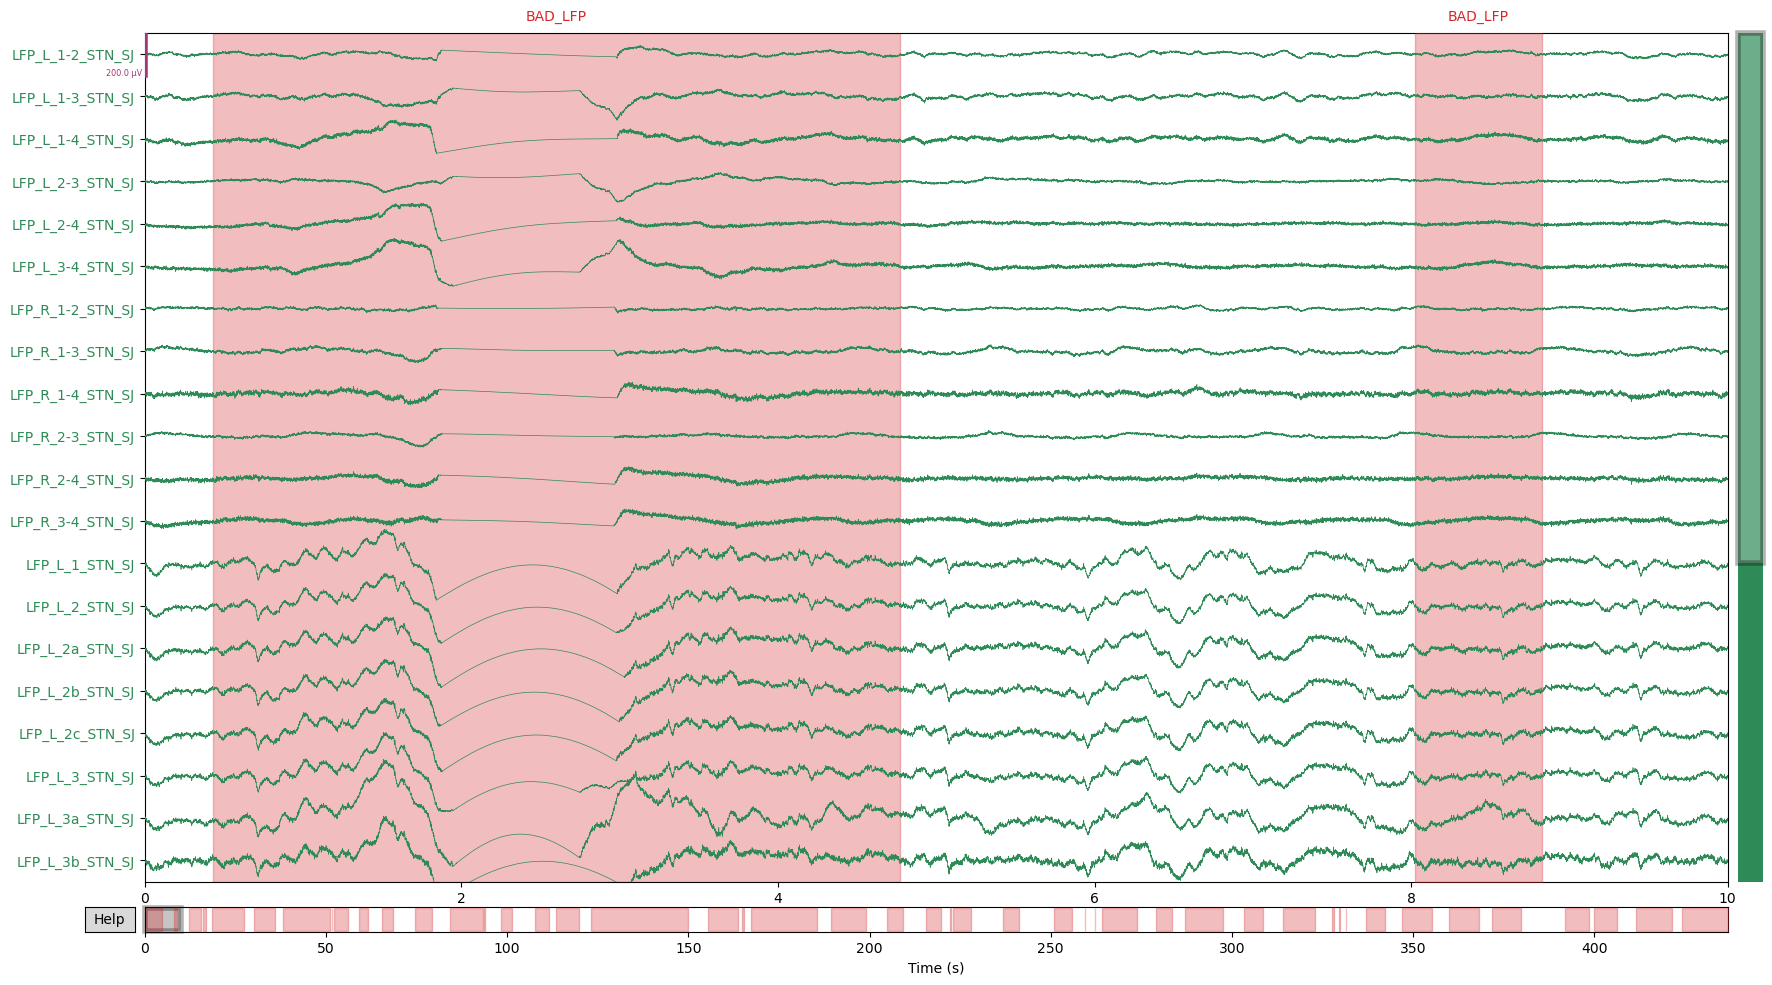

In [20]:
raw2.plot();

In [21]:
n_fft = int(raw2.info["sfreq"])
n_overlap = n_fft // 2
n_per_seg = n_fft
spectrum = raw2.compute_psd(method="welch", n_fft=n_fft, n_overlap=n_overlap, n_per_seg=n_per_seg)

Setting 527818 of 873750 (60.41%) samples to NaN, retaining 345932 (39.59%) samples.
Effective window size : 1.000 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.


/Users/moritzgerster/anaconda3/envs/local_sns013/lib/python3.12/site-packages/mne/time_frequency/psd.py:266: UserWarning: nperseg = 2000 is greater than input length  = 859, using nperseg = 859
  return _func(*args, **kwargs)


ValueError: noverlap must be less than nperseg.

In [22]:
extend_bad_segments(raw2, min_gap=1)

Measurement date,"January 01, 1970 00:00:00 GMT"
Experimenter,Unknown
Participant,FloML002
Digitized points,0 points
Good channels,32 DBS
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2000.00 Hz
Highpass,1.00 Hz
Lowpass,795.00 Hz


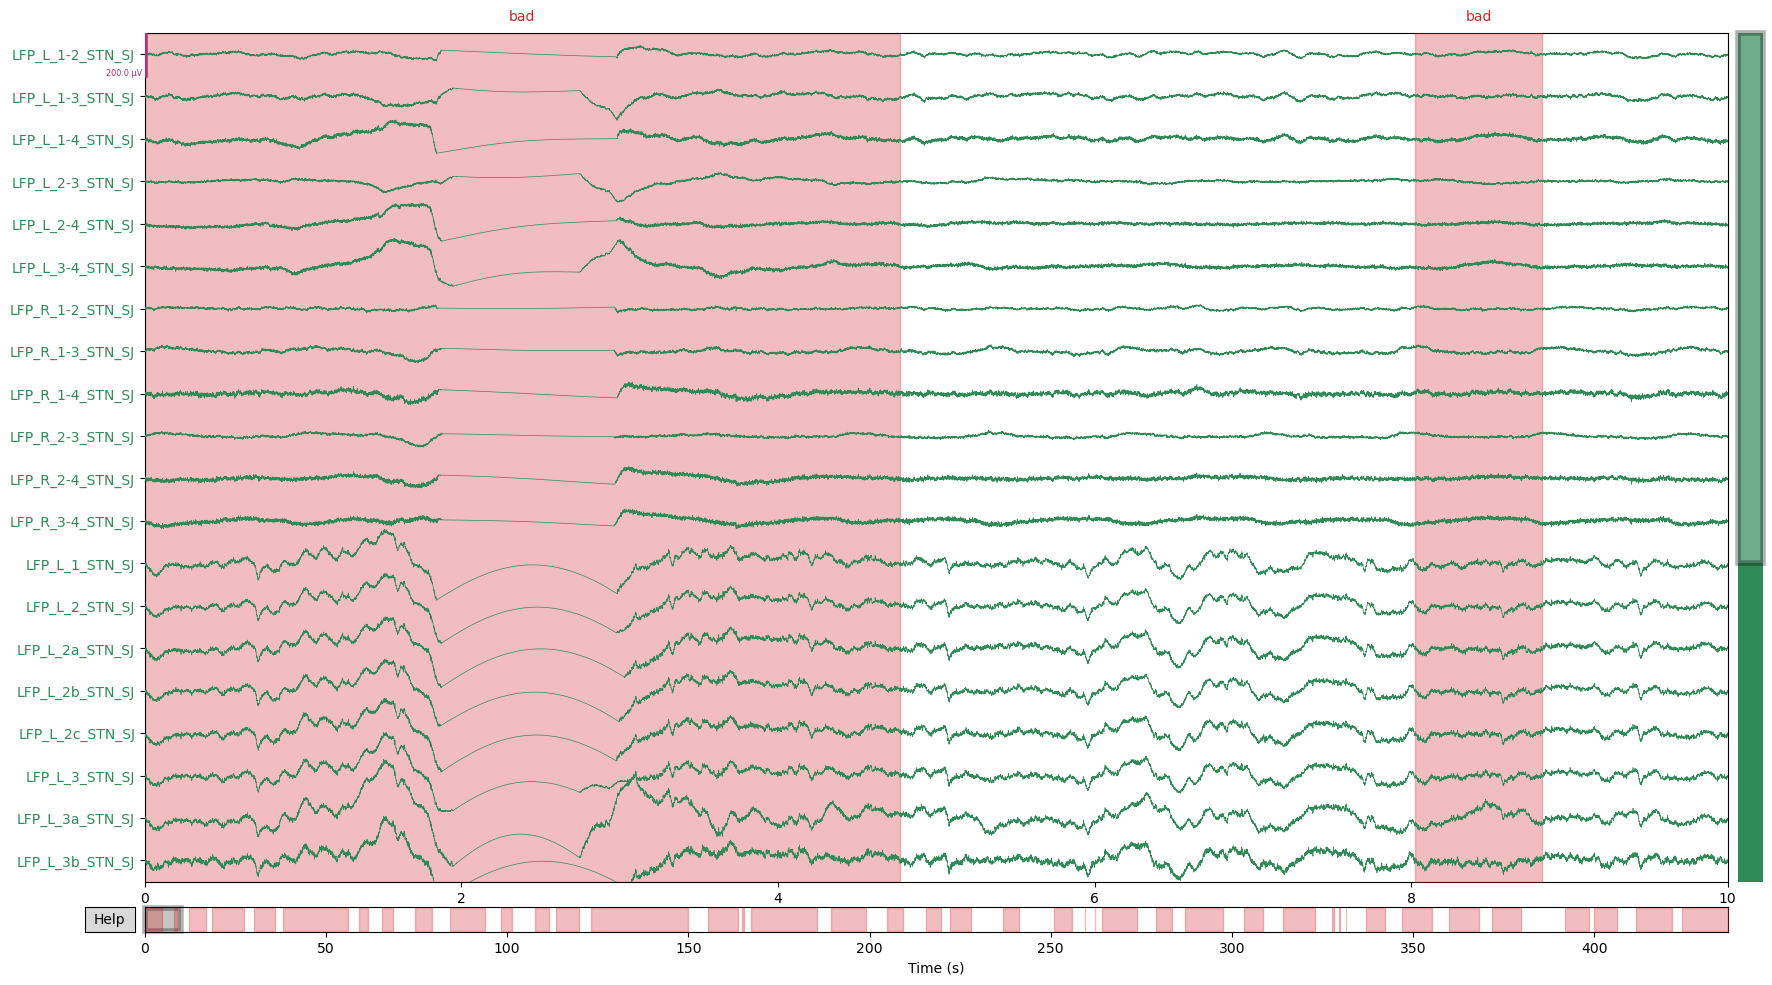

In [23]:
raw2.plot();

In [24]:
spectrum_overlap = raw2.compute_psd(method="welch", n_fft=n_fft, n_overlap=n_overlap, n_per_seg=n_per_seg)

Setting 534283 of 873750 (61.15%) samples to NaN, retaining 339467 (38.85%) samples.


Effective window size : 1.000 (s)


In [25]:
spectrum = raw2.compute_psd(method="welch", n_fft=n_fft)

Setting 534283 of 873750 (61.15%) samples to NaN, retaining 339467 (38.85%) samples.
Effective window size : 1.000 (s)


In [27]:
psd, freqs = spectrum.get_data(return_freqs=True)
psd_overlap = spectrum_overlap.get_data()

In [29]:
import matplotlib.pyplot as plt

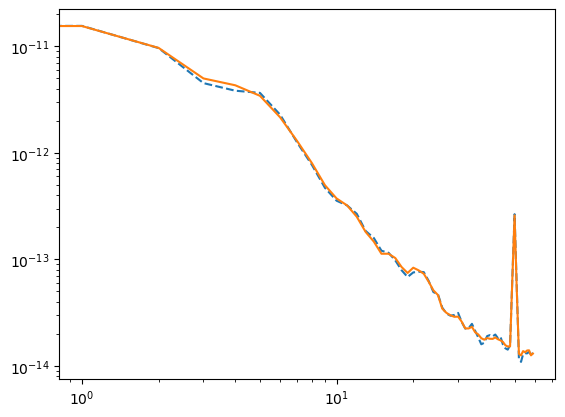

In [35]:
mask = freqs < 60
plt.loglog(freqs[mask], psd[0][mask], '--')
plt.loglog(freqs[mask], psd_overlap[0][mask])
plt.show()